In [275]:
import os
import numpy as np
import tensorflow as tf
import librosa


In [276]:
def get_audio_file_paths(directory):
    """
    Get a list of audio file paths from a given directory.

    Args:
        directory (str): Path to the directory containing .wav audio files.

    Returns:
        List[str]: List of full file paths for .wav files in the directory.
    """

    audio_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            audio_files.append(os.path.join(directory, filename))
    return audio_files

In [277]:
clean_dir = 'clean_testset_wav'
noisy_dir = 'noisy_testset_wav'

In [278]:
clean_files = get_audio_file_paths(clean_dir)
noisy_files = get_audio_file_paths(noisy_dir)

In [279]:
print(type(clean_files))
print(type(noisy_files))

<class 'list'>
<class 'list'>


In [280]:
def preprocess_audio(file_path, target_sample_rate = 32000, duration = 2, n_fft = 512, hop_length = 256):
    """
    This function loads an audio file, resamples it to a specified sample rate (target_sample_rate),  
    normalizes it to a range of [-1, 1], and then ensures a fixed length by either padding it with zeros or cropping it.

    Args:
        file_path (str): Path to the audio file.
        target_sample_rate (int): The sample rate to which audio will be resampled.
        duration (float): Target duration (in seconds) for the audio.

    Returns:
        np.ndarray: Preprocessed audio signal with fixed length.
    """

    audio, sr = librosa.load(file_path, sr = target_sample_rate)

    print(f"type of auduio just after sampling and loading: {type(audio)}")
    print(f"shape of the audio just after sampling and loading: {audio.shape}")
    print("\n-------------------------------------\n")
    
    audio = librosa.util.normalize(audio)

    target_lenght = int(target_sample_rate * duration)
    if len(audio) > target_lenght:
        print("len is greater so cropping")
        print(f"lenght of the audio before cropping: {len(audio)}")
        audio = audio[:target_lenght]
        print(f"lenght of the audio after cropping: {len(audio)}")
    else:
        print("len is smaller so padding")
        print(f"lenght of the audio before padding: {len(audio)}")
        padding = target_lenght - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
        print(f"lenght of the audio after padding: {len(audio)} ")

    print(f'\nshape of the audio just before stft: {audio.shape}\n')
    print('----------------------------------------\n')
    stft = librosa.stft(audio, n_fft = n_fft, hop_length = hop_length)
    print(f'type of stft: {type(stft)}')
    print(f'shape of stft: {stft.shape}')

    print('\n----------------------------------------\n')
    magnitude = np.abs(stft)        # extracting only magnitude and excluding phase
    print(f'type of magnitude: {type(magnitude)}')
    print(f'shape of magnitude: {magnitude.shape}')

    return magnitude


## experimenting on a single file

In [281]:
print(noisy_files[0])

noisy_testset_wav/p257_207.wav


In [282]:
import IPython.display as ipd

ipd.Audio(noisy_files[0])

### Time-Domain audio (before STFT)

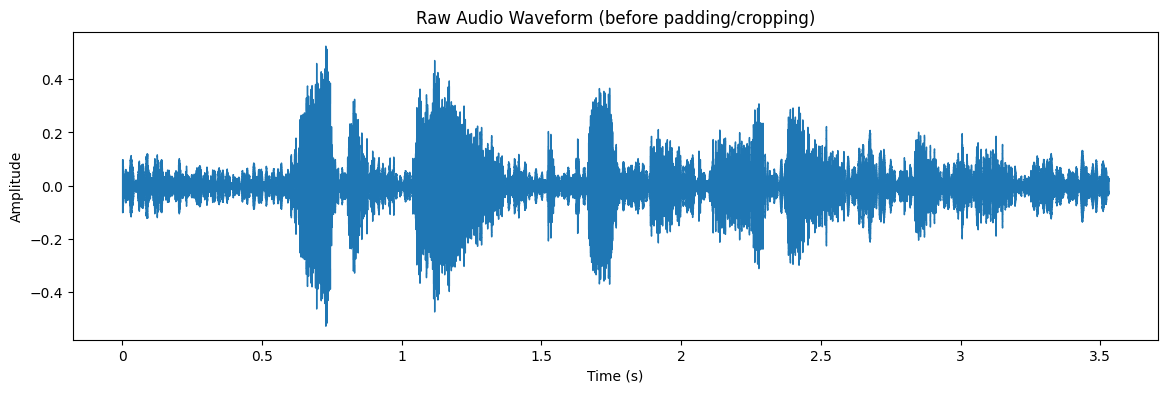

In [285]:
import matplotlib.pyplot as plt

audio, sr = librosa.load(noisy_files[0], sr = 32000)

# Plot raw waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio, sr=32000)
plt.title("Raw Audio Waveform (before padding/cropping)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [253]:
noisy_audio_1 = preprocess_audio(noisy_files[0])

type of auduio just after sampling and loading: <class 'numpy.ndarray'>
shape of the audio just after sampling and loading: (112954,)

-------------------------------------

len is greater so cropping
lenght of the audio before cropping: 112954
lenght of the audio after cropping: 64000

shape of the audio just before stft: (64000,)

----------------------------------------

type of stft: <class 'numpy.ndarray'>
shape of stft: (257, 251)

----------------------------------------

type of magnitude: <class 'numpy.ndarray'>
shape of magnitude: (257, 251)


### time-frequency audio (after STFT)

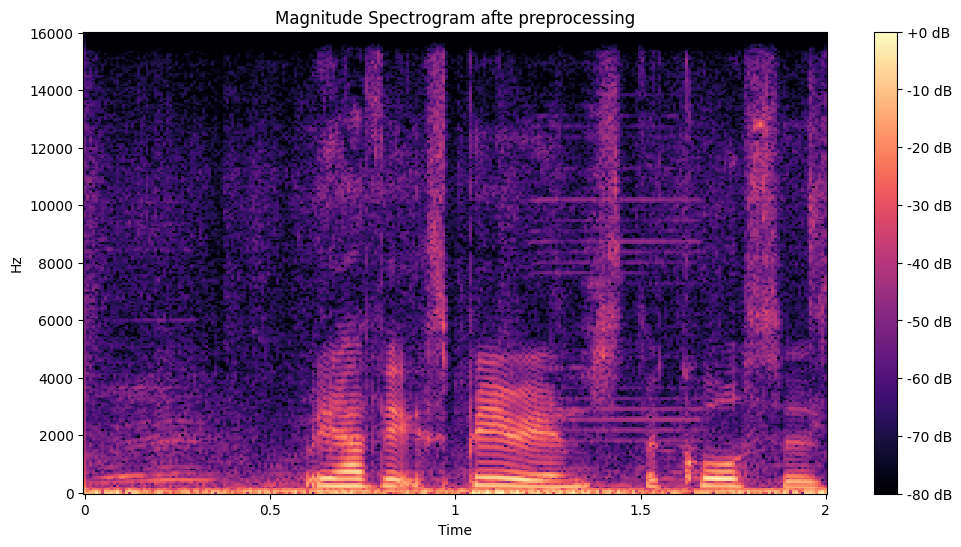

In [286]:
# Plot magnitude spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(librosa.amplitude_to_db(noisy_audio_1, ref=np.max),
                             sr=32000, hop_length=256, x_axis='time', y_axis='linear')
plt.title("Magnitude Spectrogram afte preprocessing")
plt.colorbar(format='%+2.0f dB')
plt.show()

 Here, we are taking **32,000** samples per second as described in our **preprocess_audio()** and since duration of this audio clip is 3 seconds we should normally get **32,000 * 3 = 96,0000** samples as the lenght but i think the audio file is not exactly 3 it is somewhere in between 3 and 4 hence the no of samples we got were between 96,0000 and 128,0000 i.e 112954

**dimensions after stft** = $(no\_of\_frequency\_bins, no\_of\_time\_frames)$

## Formulae:
$frequency\_bins = n\_fft/2  + 1$

$no\_of\_time\_frames = (no\_of\_samples - n\_fft)/hop\_length + 1$


#### **Note:**
In $librosa.stft()$ by default **center = True**

- this means librosa pads your signal before performing STFT.
- it pads both sides by $n\_fft/2$


### Applying formulae:
$n\_fft = 512$ 

$hop\_length = 256$

$frequency\_bins = 512/2  + 1$ = $257$

$no\_of\_time\_frames = ((64000 + 2 * 256) - 512)/256 + 1$ = $251$

Hence, the final dimensions are $(257, 251)$



## Making lists of Numpy arrays

In [255]:
clean_signals = []
noisy_signals = []

for clean_fp, noisy_fp in zip(clean_files, noisy_files):
    clean_mag = preprocess_audio(clean_fp)
    noisy_mag = preprocess_audio(noisy_fp)
    
    clean_signals.append(clean_mag)
    noisy_signals.append(noisy_mag)

type of auduio just after sampling and loading: <class 'numpy.ndarray'>
shape of the audio just after sampling and loading: (112954,)

-------------------------------------

len is greater so cropping
lenght of the audio before cropping: 112954
lenght of the audio after cropping: 64000

shape of the audio just before stft: (64000,)

----------------------------------------

type of stft: <class 'numpy.ndarray'>
shape of stft: (257, 251)

----------------------------------------

type of magnitude: <class 'numpy.ndarray'>
shape of magnitude: (257, 251)
type of auduio just after sampling and loading: <class 'numpy.ndarray'>
shape of the audio just after sampling and loading: (112954,)

-------------------------------------

len is greater so cropping
lenght of the audio before cropping: 112954
lenght of the audio after cropping: 64000

shape of the audio just before stft: (64000,)

----------------------------------------

type of stft: <class 'numpy.ndarray'>
shape of stft: (257, 251)



In [256]:
print(clean_signals[0].shape)
print(type(clean_signals[0]))
print(f"type of clean_signals: {type(clean_signals)}")
print(f'length of the list clean_signals: {len(clean_signals)}')
print("\n--------------------\n")
print(noisy_signals[0].shape)
print(type(noisy_signals[0]))
print(f"type of noisy_signals: {type(noisy_signals)}")
print(f'length of the list clean_signals: {len(clean_signals)}')




(257, 251)
<class 'numpy.ndarray'>
type of clean_signals: <class 'list'>
length of the list clean_signals: 824

--------------------

(257, 251)
<class 'numpy.ndarray'>
type of noisy_signals: <class 'list'>
length of the list clean_signals: 824


- the clean_signals and noisy_signals both are of type list and each element in them is a numpy array of shape $(257, 251)$

## converting list to a 2d numpy array

In [257]:
clean_signals = np.array(clean_signals)
print(f"type of clean_signals after array conversion : {type(clean_signals)}")
print(f"shape of clean_signals after array conversion: {clean_signals.shape}")
print("\n--------------------------------------------------\n")
noisy_signals = np.array(noisy_signals)
print(f"type of noisy_signals after array conversion : {type(noisy_signals)}")
print(f"shape of noisy_signals after array conversion: {noisy_signals.shape}")


type of clean_signals after array conversion : <class 'numpy.ndarray'>
shape of clean_signals after array conversion: (824, 257, 251)

--------------------------------------------------

type of noisy_signals after array conversion : <class 'numpy.ndarray'>
shape of noisy_signals after array conversion: (824, 257, 251)


 the final shapes of the arrays have now become 

 $(length\_of\_the\_list,\ no\_of\_frquency\_bins,\  no\_of\_time\_frames)$


## adding channels dimension to the 2d arrays

In [258]:
clean_signals = np.expand_dims(clean_signals, axis = -1)
print(f"shape of the clean_signals after expansion: {clean_signals.shape}")
print("\n--------------------------------------------\n")

noisy_signals = np.expand_dims(noisy_signals, axis = -1)
print(f"shape of the noisy_signals after expansion: {noisy_signals.shape}")


shape of the clean_signals after expansion: (824, 257, 251, 1)

--------------------------------------------

shape of the noisy_signals after expansion: (824, 257, 251, 1)


## building model

In [259]:
def build_autoencoder(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    # 🟢 Final layer should output **1 channel**
    decoded = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='relu')(x)


    # Crop to match input
    decoded = tf.keras.layers.Cropping2D(((0, x.shape[1] - input_shape[0]), (0, x.shape[2] - input_shape[1])))(decoded)

    model = tf.keras.Model(inputs, decoded)
    model.compile(optimizer='adam', loss='mse')
    
    return model


In [260]:
input_shape = (clean_signals.shape[1], clean_signals.shape[2], 1)
autoencoder = build_autoencoder(input_shape)

In [261]:
autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 257, 251, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 257, 251, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 129, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 129, 126, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 65, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 65, 63, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 130, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 130, 126, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 260, 252, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 260, 252, 1)    │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_8 (Cropping2D)       │ (None, 257, 251, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [262]:
autoencoder.fit(noisy_signals, clean_signals, epochs=10, batch_size=16, validation_split=0.1)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - loss: 1.5050 - val_loss: 0.7141
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 470ms/step - loss: 0.6004 - val_loss: 0.5187
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 567ms/step - loss: 0.4950 - val_loss: 0.4205
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 507ms/step - loss: 0.4178 - val_loss: 0.3592
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 535ms/step - loss: 0.3611 - val_loss: 0.3364
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 524ms/step - loss: 0.3302 - val_loss: 0.3029
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 514ms/step - loss: 0.2991 - val_loss: 0.2873
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 562ms/step - loss: 0.2828 - val_loss: 0.2790
Epoch 9/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 549ms/step - loss: 0.2777 - val_loss: 0.2805
Epoch 10/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 579ms/step - loss: 0.2713 - val_loss: 0.2549


In [132]:
import soundfile as sf

## pre processing the new test data

In [263]:
def denoise_long_audio(input_file, output_file, model, target_sample_rate=32000, duration=2.0, n_fft=512, hop_length=256, overlap=0.50):
    # Step 1: Load & normalize audio
    audio, sr = librosa.load(input_file, sr=target_sample_rate)
    audio = librosa.util.normalize(audio)

    target_length = int(target_sample_rate * duration)  # chunk size (e.g., 2 seconds = 32000 samples)
    step_size = int(target_length * (1 - overlap))     # step size with overlap

    denoised_audio = np.zeros(len(audio) + target_length)  # Extra space for overlap
    overlap_count = np.zeros(len(audio) + target_length)   # To normalize overlap
    window = np.hanning(target_length)  # smoother overlap-add

    start_positions = []

    # Step 2: Main chunk processing loop
    for start in range(0, len(audio) - target_length + 1, step_size):
        start_positions.append(start)
        chunk = audio[start:start + target_length]

        # STFT
        stft = librosa.stft(chunk, n_fft=n_fft, hop_length=hop_length)
        mag = np.abs(stft)
        phase = np.angle(stft)

        # Predict
        mag_input = np.expand_dims(mag, axis=(0, -1))
        denoised_mag = model.predict(mag_input)
        denoised_mag = denoised_mag.squeeze()

        # iSTFT
        denoised_stft = denoised_mag * np.exp(1j * phase)
        denoised_chunk = librosa.istft(denoised_stft, hop_length=hop_length)

        # Overlap-add
        denoised_audio[start:start + target_length] += denoised_chunk[:target_length] * window
        overlap_count[start:start + target_length] += window

    # Step 3: Handle the leftover tail
    if start_positions:
        tail_start = start_positions[-1] + step_size
    else:
        # If no chunks were processed (audio < target_length)
        tail_start = 0

    if tail_start < len(audio):
        tail = audio[tail_start:]
        pad_len = target_length - len(tail)
        tail_padded = np.pad(tail, (0, pad_len), mode='constant')

        # STFT
        stft = librosa.stft(tail_padded, n_fft=n_fft, hop_length=hop_length)
        mag = np.abs(stft)
        phase = np.angle(stft)

        # Predict
        mag_input = np.expand_dims(mag, axis=(0, -1))
        denoised_mag = model.predict(mag_input)
        denoised_mag = denoised_mag.squeeze()

        # iSTFT
        denoised_stft = denoised_mag * np.exp(1j * phase)
        denoised_chunk = librosa.istft(denoised_stft, hop_length=hop_length)

        # Add only the non-padded part
        valid_len = len(tail)
        denoised_audio[tail_start:tail_start + valid_len] += denoised_chunk[:valid_len] * window[:valid_len]
        overlap_count[tail_start:tail_start + valid_len] += window[:valid_len]

    # Step 4: Normalize by overlap count
    overlap_count = np.where(overlap_count == 0, 1, overlap_count)
    denoised_audio = denoised_audio[:len(audio)] / overlap_count[:len(audio)]

    # Step 5: Normalize and Save
    denoised_audio = librosa.util.normalize(denoised_audio)
    sf.write(output_file, denoised_audio, target_sample_rate)
    print(f"✅ Denoised long audio saved to: {output_file}")


In [264]:
input_wav = "noisy_testset_wav/p257_207.wav"
output_wav = "denoised_stft_audio_long.wav"

denoise_long_audio(input_wav, output_wav, autoencoder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
✅ Denoised long audio saved to: denoised_stft_audio_long.wav
